<img
src="https://www.imt-atlantique.fr/sites/default/files/Images/Ecole/charte-graphique/IMT_Atlantique_logo_RVB_Baseline_400x272.jpg">

<CENTER>
</br>
<p><font size="5"> Big Data & Cloud Computing</span></p>
<p><font size="4">  Project 6 </font></p>
<p></p>
<p><font size="5">  Ocean warming contribution to Sea level rise </font></p>
</p></br>
</p>
</CENTER>

<p><font size="3"> Houda GHALLAB - Yassine SAOUD - Aymane HOUNA - Pierrot LEVASSEUR  </font></p>

----------------------------

## Installing requirements

In [1]:
!pip install basemap intake intake-xarray zarr dask cartopy

# Importing libraries

In [2]:
%matplotlib inline
%pylab inline
from mpl_toolkits.basemap import Basemap
import sklearn
import pandas as pd
from scipy.stats.mstats import zscore
import warnings
import xarray as xr
warnings.filterwarnings("ignore") # disable warnings
pylab.rcParams['figure.figsize']=(15,15) # graph size

Populating the interactive namespace from numpy and matplotlib


# Declaring functions

In [3]:
# function to plot images
def plot_im(lon,lat,im,size_points,var_name):

    # transform to arrays (just in case)
    lon=array(lon)
    lat=array(lat)
    im=array(im)

    if max(lon)-min(lon)<100:
      # Mercator projection (for small zone)
      m=Basemap(projection='merc',llcrnrlat=nanmin(lat),urcrnrlat=nanmax(lat),\
                llcrnrlon=nanmin(lon),urcrnrlon=nanmax(lon),lat_0=(nanmax(lat)+nanmin(lat))*0.5,\
                lon_0=(nanmax(lon)+nanmin(lon))*0.5,resolution='l')
    else:
      # Orthogonal projection (for large zone)
      m=Basemap(projection='robin',lat_0=0,lon_0=0,resolution='l')
    # you can use other projections (see https://matplotlib.org/basemap/users/mapsetup.html)

    # transform (lon,lat) to (x,y)
    x,y=m(lon,lat)

    # plot
    #im=ma.masked_where(isnan(im),im)
    res=m.scatter(x,y,size_points,im,'o',alpha=1,cmap='jet',lw=0)
    m.drawcoastlines()
    m.fillcontinents()
    parallels = linspace(nanmin(lat),nanmax(lat),15)
    meridians = linspace(nanmin(lon),nanmax(lon),15)
    #m.drawparallels(parallels,labels=[1,0,0,1],fontsize=10)
    #m.drawmeridians(meridians,labels=[1,0,0,1],fontsize=10)
    cb=m.colorbar(res,location="right")
    cb.set_label(var_name,fontsize=15)

# function to plot time series
def plot_ts(time,ts,line_type,var_name):

    # plot
    plot_date(time-719177.25,ts,line_type)
    xlabel('Time',fontsize=15)
    ylabel(var_name,fontsize=15)

# Importing data

In [4]:
import os
os.environ['USE_AUTH_EPHEM'] = '0'

from google.colab import auth
auth.authenticate_user()

In [5]:
from intake import open_catalog
catalog_url = 'https://raw.githubusercontent.com/obidam/ds2-2024/main/ds2_data_catalog.yml'
cat = open_catalog(catalog_url)
ds = cat["en4"].to_dask()

In [6]:
ds

<xarray.Dataset>
Dimensions:                          (depth: 42, time: 832, bnds: 2, lat: 173,
                                      lon: 360)
Coordinates:
  * depth                            (depth) float32 5.022 15.08 ... 5.35e+03
  * lat                              (lat) float32 -83.0 -82.0 ... 88.0 89.0
  * lon                              (lon) float32 1.0 2.0 3.0 ... 359.0 360.0
  * time                             (time) datetime64[ns] 1950-01-16T12:00:0...
Dimensions without coordinates: bnds
Data variables:
    depth_bnds                       (time, depth, bnds) float32 dask.array<chunksize=(1, 42, 2), meta=np.ndarray>
    salinity                         (time, depth, lat, lon) float32 dask.array<chunksize=(1, 42, 173, 360), meta=np.ndarray>
    salinity_observation_weights     (time, depth, lat, lon) float32 dask.array<chunksize=(1, 42, 173, 360), meta=np.ndarray>
    salinity_uncertainty             (time, depth, lat, lon) float32 dask.array<chunksize=(1, 42, 173, 360), meta=np.ndarray>
    temperature                      (time, depth, lat, lon) float32 dask.array<chunksize=(1, 42, 173, 360), meta=np.ndarray>
    temperature_observation_weights  (time, depth, lat, lon) float32 dask.array<chunksize=(1, 42, 173, 360), meta=np.ndarray>
    temperature_uncertainty          (time, depth, lat, lon) float32 dask.array<chunksize=(1, 42, 173, 360), meta=np.ndarray>
    time_bnds                        (time, bnds) datetime64[ns] dask.array<chunksize=(832, 2), meta=np.ndarray>
Attributes: (12/21)
    Conventions:            CF-1.0
    DSD_entry_id:           UKMO-L4UHFnd-GLOB-v01
    GDS_version_id:         v1.7
    contact:                Simon Good - simon.good@metoffice.gov.uk
    creation_date:          2017-04-21 21:12:08.123 -00:00
    easternmost_longitude:  362.5
    ...                     ...
    start_date:             2001-01-01 UTC
    start_time:             00:00:00 UTC
    stop_date:              2001-01-01 UTC
    stop_time:              00:00:00 UTC
    title:                  Temperature and salinity analysis
    westernmost_longitude:  0.5

In [7]:
import numpy as np

We calculate the elementary area of the ocean

In [8]:
R = 6.37e6
# we know already that the spacing of the points is one degree latitude
dϕ = np.deg2rad(1.)
dλ = np.deg2rad(1.)
dA = R**2 * dϕ * dλ * np.cos(np.deg2rad(ds.lat))

In [9]:
salinity = ds['salinity']

In [10]:
pixel_area = dA.where(salinity.notnull())

The last coordinate to calculate is the volume which is evaluated by taking the derivative of the depth of the ocean

In [11]:
depths = salinity['depth']
dz = depths.diff(dim='depth')
dz = xr.concat([xr.DataArray([5.022], dims='depth', coords={'depth': [5.022]}), dz], dim='depth')

In [12]:
dV = dA * dz

We start by plotting a volumetric mean salinity Time Series

In [13]:
salinity_time_series = (salinity * dV).sum(dim=('lat', 'lon', 'depth')) / (dV.sum(dim=('lat', 'depth')) * 360)

In [14]:
time = salinity['time']

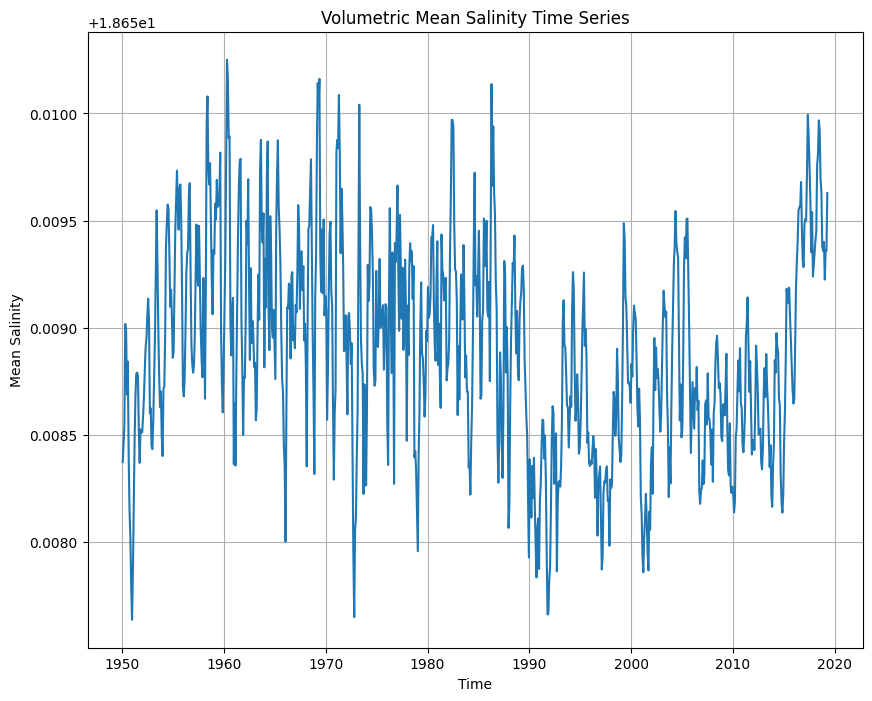

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(time, salinity_time_series)
plt.title('Volumetric Mean Salinity Time Series')
plt.xlabel('Time')
plt.ylabel('Mean Salinity')
plt.grid(True)
plt.show()

To observe the general tendency of salinity's variation we can smooth the curve via a running average, the window being 12 which corresponds to 1 year

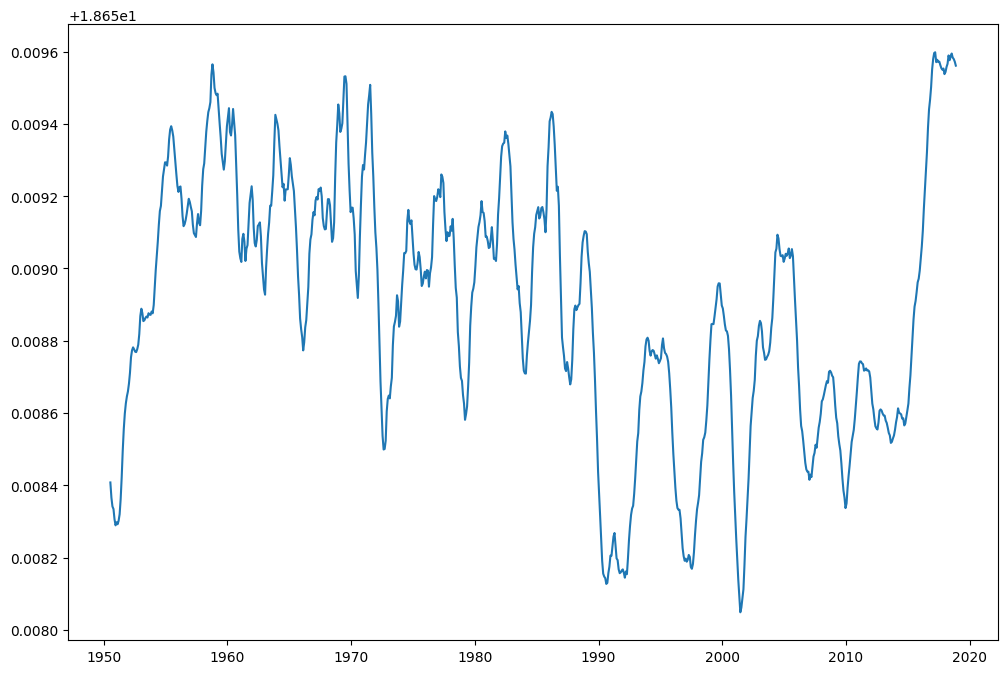

In [ ]:
window_size = 12

running_avg_salinity = salinity_time_series.rolling(time=window_size, center=True).mean()

plt.figure(figsize=(12,8))
plt.plot(time, running_avg_salinity)
plt.show()

We plot after that the mean salinity map for the first date

In [ ]:
salinity_map = (salinity[0] * dz).sum(dim=('depth')) / (dz.sum(dim=('depth')))

In [17]:
LON, LAT = meshgrid(salinity['lon'] , salinity['lat'])

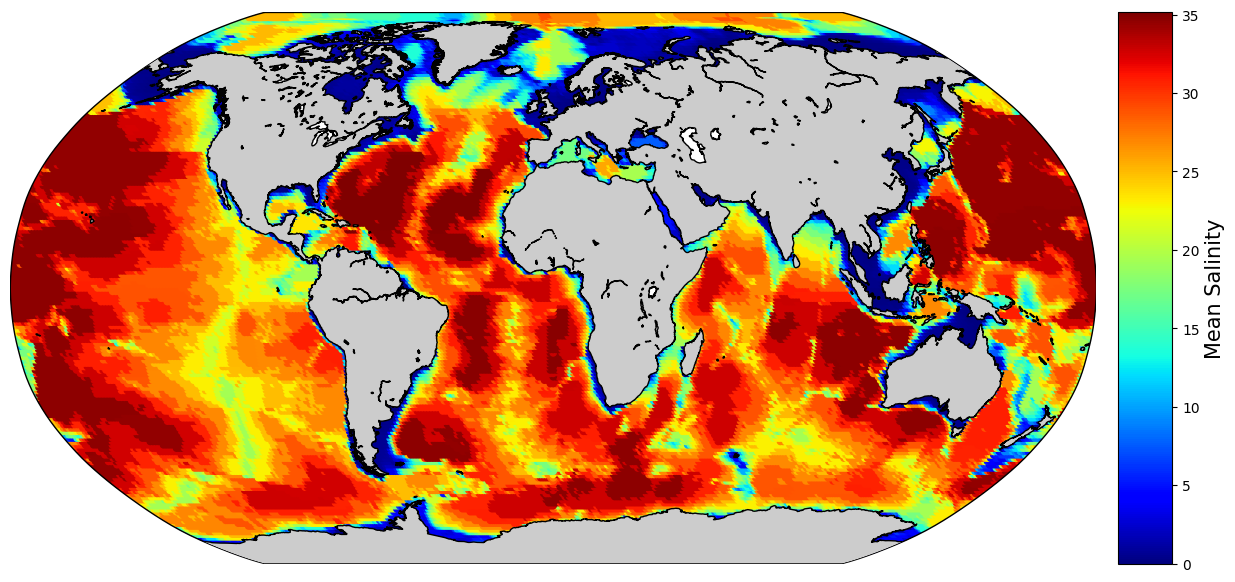

In [ ]:
plot_im(ravel(LON), ravel(LAT), ravel(salinity_map), 30, 'Mean Salinity')

The mean map for all the dates :

In [18]:
map = (salinity * dz).sum(dim=('depth')) / (dz.sum(dim=('depth')))
mean_salinity_map = map.mean(dim='time')

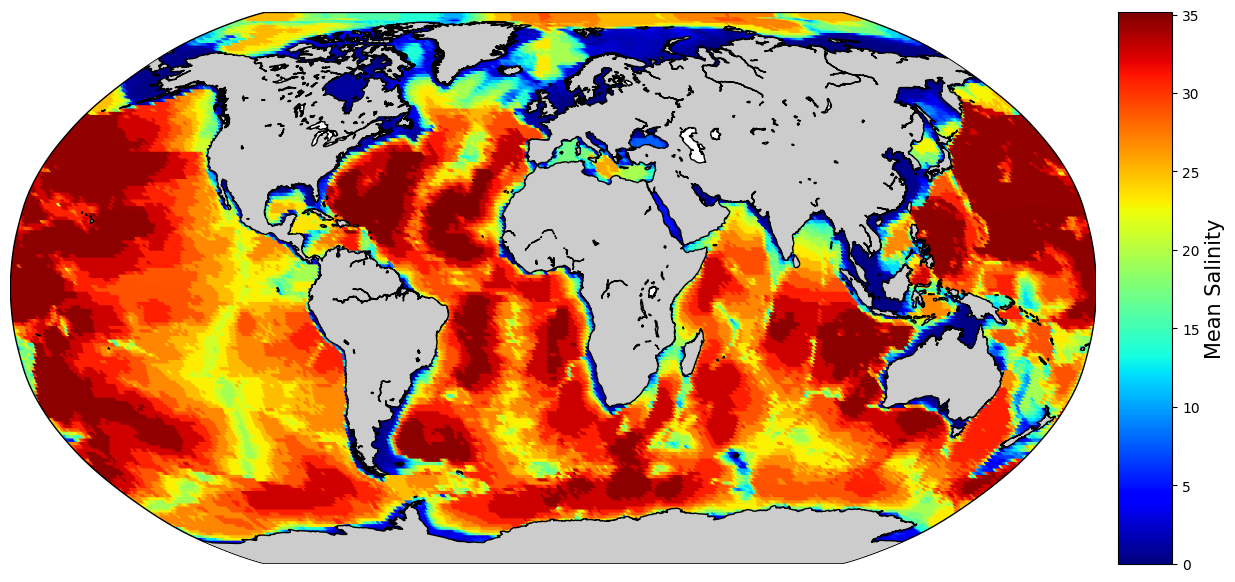

In [19]:
plot_im(ravel(LON), ravel(LAT), ravel(mean_salinity_map), 30, 'Mean Salinity')

We start by plotting a volumetric mean salinity Time Series under 100m meters' depth

In [20]:
depths_under_100m = salinity.sel(depth=slice(None, 100))
dz_under_100m = depths_under_100m['depth'].diff(dim='depth')
dz_under_100m = xr.concat([xr.DataArray([5.022], dims='depth', coords={'depth': [5.022]}), dz_under_100m], dim='depth')
dv_under_100m = dA * dz_under_100m

salinity_time_series_under_100m = (salinity * dv_under_100m).sum(dim=('lat', 'lon', 'depth')) / (dv_under_100m.sum(dim=('lat', 'depth')) * 360)

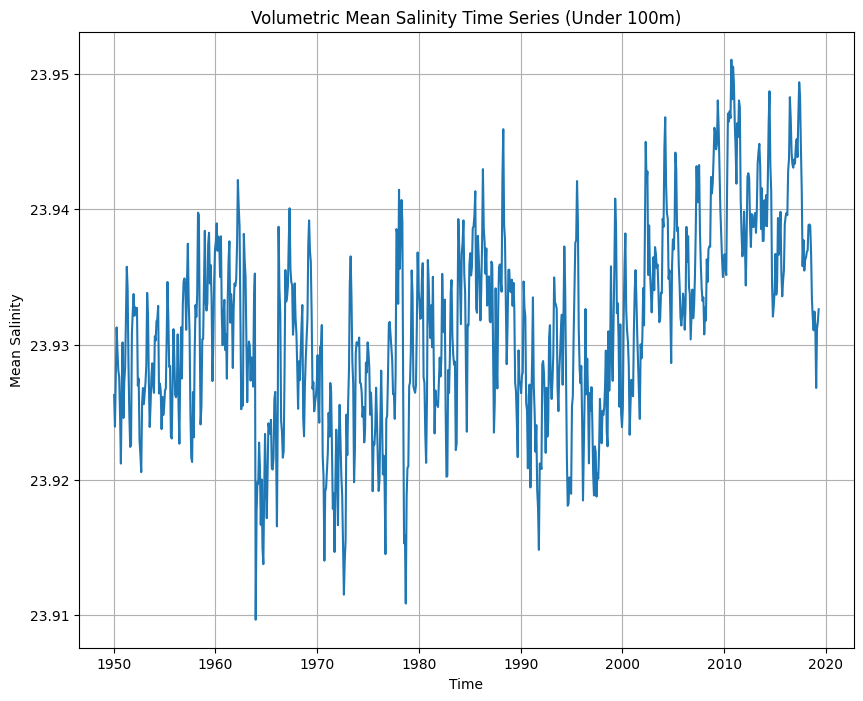

In [21]:
plt.figure(figsize=(10,8))
plt.plot(time, salinity_time_series_under_100m)
plt.title('Volumetric Mean Salinity Time Series (Under 100m)')
plt.xlabel('Time')
plt.ylabel('Mean Salinity')
plt.grid(True)
plt.show()

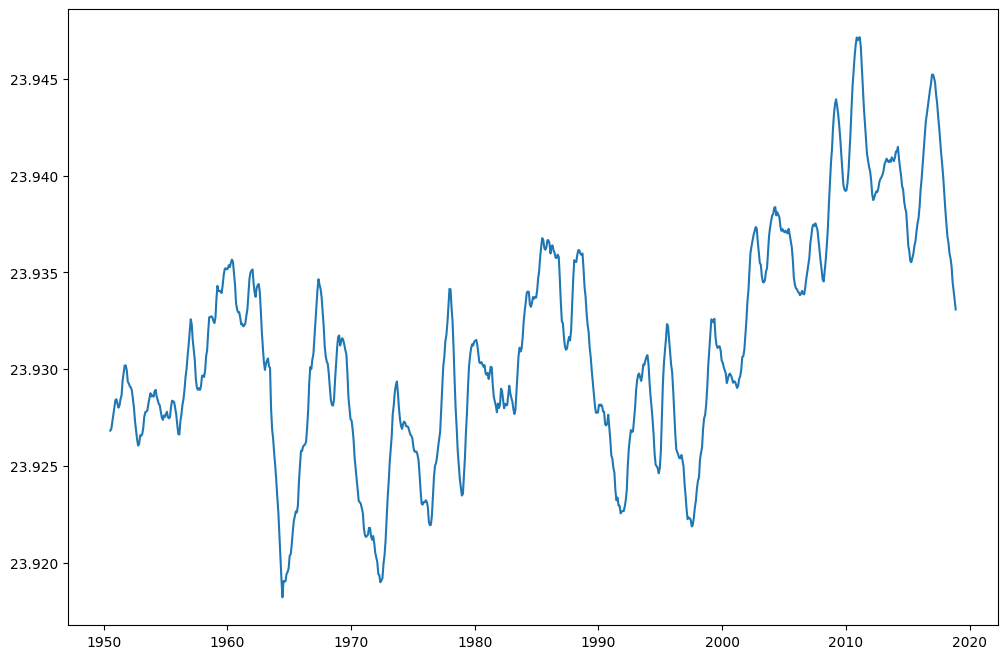

In [22]:
window_size = 12

running_avg_salinity_under_100m = salinity_time_series_under_100m.rolling(time=window_size, center=True).mean()

plt.figure(figsize=(12,8))
plt.plot(time, running_avg_salinity_under_100m)
plt.show()

The same mean map as before but only for depths under 100 meters

In [23]:
map_under_100m = (salinity * dz_under_100m).sum(dim=('depth')) / (dz_under_100m.sum(dim=('depth')))
mean_salinity_map_under_100m = map_under_100m.mean(dim='time')

In [24]:
#The same function "plot_im" with the definition of "vmin" and "vmax"
def plot_im2(lon,lat,im,size_points,var_name, vmin, vmax):

    # transform to arrays (just in case)
    lon=array(lon)
    lat=array(lat)
    im=array(im)

    if max(lon)-min(lon)<100:
      # Mercator projection (for small zone)
      m=Basemap(projection='merc',llcrnrlat=nanmin(lat),urcrnrlat=nanmax(lat),\
                llcrnrlon=nanmin(lon),urcrnrlon=nanmax(lon),lat_0=(nanmax(lat)+nanmin(lat))*0.5,\
                lon_0=(nanmax(lon)+nanmin(lon))*0.5,resolution='l')
    else:
      # Orthogonal projection (for large zone)
      m=Basemap(projection='robin',lat_0=0,lon_0=0,resolution='l')
    # you can use other projections (see https://matplotlib.org/basemap/users/mapsetup.html)

    # transform (lon,lat) to (x,y)
    x,y=m(lon,lat)

    # plot
    #im=ma.masked_where(isnan(im),im)
    res=m.scatter(x,y,size_points,im,'o',alpha=1,cmap='jet',lw=0, vmin= vmin, vmax=vmax)
    m.drawcoastlines()
    m.fillcontinents()
    parallels = linspace(nanmin(lat),nanmax(lat),15)
    meridians = linspace(nanmin(lon),nanmax(lon),15)
    #m.drawparallels(parallels,labels=[1,0,0,1],fontsize=10)
    #m.drawmeridians(meridians,labels=[1,0,0,1],fontsize=10)
    cb=m.colorbar(res,location="right")
    cb.set_label(var_name,fontsize=15)

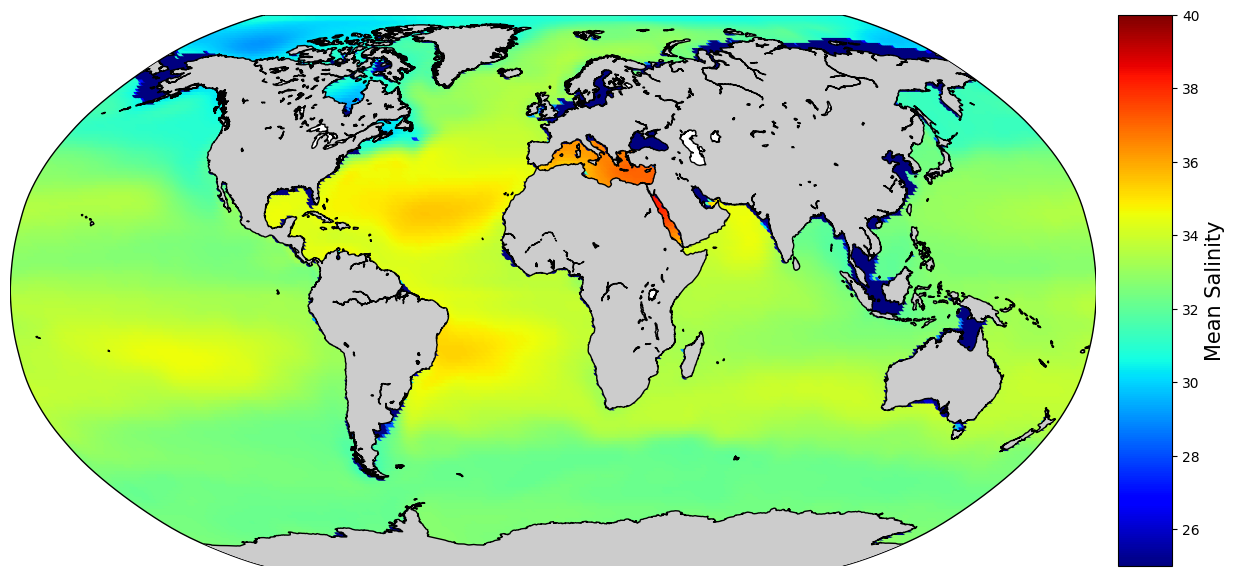

In [25]:
plot_im2(ravel(LON), ravel(LAT), ravel(mean_salinity_map_under_100m), 30, 'Mean Salinity', vmin=25, vmax=40)

In [26]:
depths_1000_3000 = salinity.sel(depth=slice(1000, 3000))
dz_1000_3000 = depths_1000_3000['depth'].diff(dim='depth')
dz_1000_3000 = xr.concat([xr.DataArray([5.022], dims='depth', coords={'depth': [5.022]}), dz_1000_3000], dim='depth')
dv_1000_3000 = dA * dz_1000_3000

salinity_time_series_1000_3000 = (salinity * dv_1000_3000).sum(dim=('lat', 'lon', 'depth')) / (dv_1000_3000.sum(dim=('lat', 'depth')) * 360)

We start by plotting a volumetric mean salinity Time Series for depths between 1000 and 3000 meters

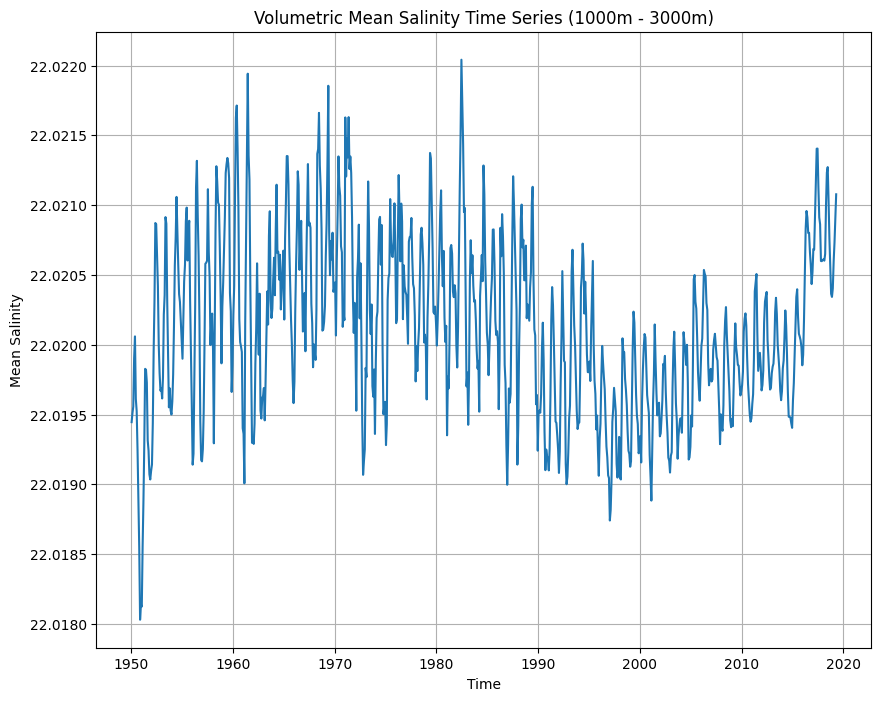

In [27]:
plt.figure(figsize=(10,8))
plt.plot(time, salinity_time_series_1000_3000)
plt.title('Volumetric Mean Salinity Time Series (1000m - 3000m)')
plt.xlabel('Time')
plt.ylabel('Mean Salinity')
plt.grid(True)
plt.show()

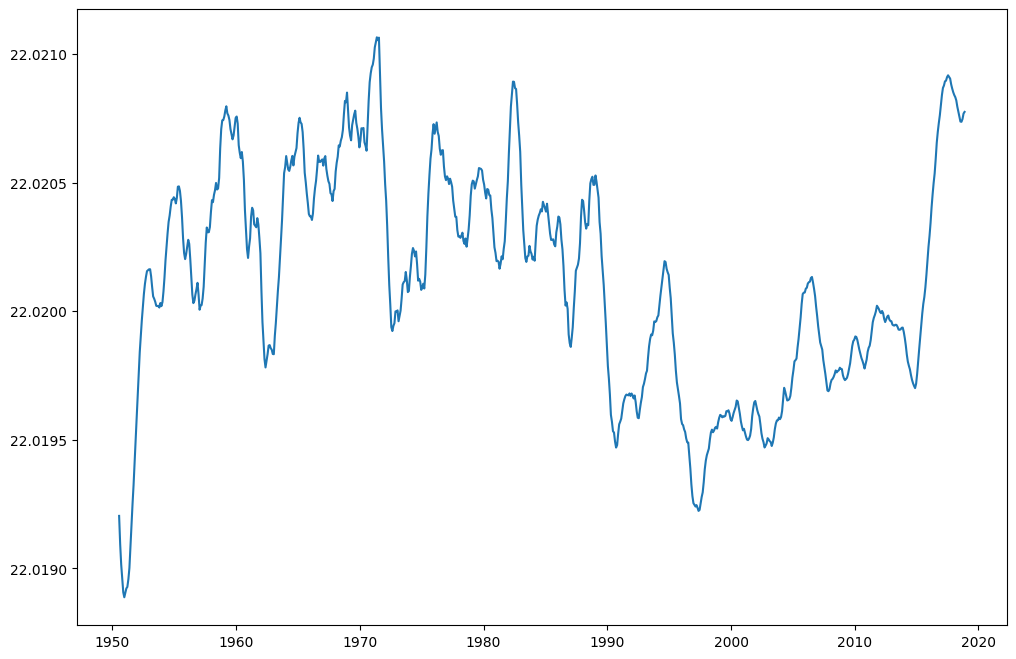

In [28]:
window_size = 12

running_avg_salinity_1000_3000 = salinity_time_series_1000_3000.rolling(time=window_size, center=True).mean()

plt.figure(figsize=(12,8))
plt.plot(time, running_avg_salinity_1000_3000)
plt.show()